# Jet Compression using an Autoencoder

In [1]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

## Loading and preparing the data

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


In [3]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


## Normalizing and splitting into train and test datasets

In [4]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Training

In [5]:
def mse_loss(input, target, size_average=None, reduce=None, reduction='mean'):
    # type: (Tensor, Tensor, Optional[bool], Optional[bool], str) -> Tensor
    r"""mse_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor

    Measures the element-wise mean squared error.

    See :class:`~torch.nn.MSELoss` for details.
    """
    if not (target.size() == input.size()):
        warnings.warn("Using a target size ({}) that is different to the input size ({}). "
                      "This will likely lead to incorrect results due to broadcasting. "
                      "Please ensure they have the same size.".format(target.size(), input.size()),
                      stacklevel=2)
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)

    ret = (input - target) ** 2
    factor = torch.full(ret.size(), 1)
    factor[:, 2] = 2.4
    ret = ret * factor
    if reduction != 'none':
        ret = torch.mean(ret) if reduction == 'mean' else torch.sum(ret)

    return ret

In [6]:
bs = 256  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()
loss_func = mse_loss

In [7]:
class AE_2D_v1000(nn.Module):
    def __init__(self, n_features=4):
        super(AE_2D_v1000, self).__init__()
        self.en1 = nn.Linear(n_features, 1000)
        self.en2 = nn.Linear(1000, 400)
        self.en3 = nn.Linear(400, 100)
        self.en4 = nn.Linear(100, 2)
        self.de1 = nn.Linear(2, 100)
        self.de2 = nn.Linear(100, 400)
        self.de3 = nn.Linear(400, 1000)
        self.de4 = nn.Linear(1000, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [8]:
n_features = len(train.loc[0])
model = AE_2D_v1000(n_features=n_features)

In [9]:
# Training
#epochs_list = [7, 5, 3, 2, 2]
#epochs_list = [40, 40, 20, 20, 20]
epochs_list = [4, 15, 40, 40, 40]
lrs = [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    #opt = optim.SGD(model.parameters(), lr=lrs[ii], momentum=0.9, nesterov=True)
    #opt = optim.RMSprop(model.parameters(), lr=lrs[ii], momentum=0.9)
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-03
Epoch 0: Validation loss = 0.09203070640723672 Time: 0:06:03.349950
Epoch 1: Validation loss = 0.07853028178105455 Time: 0:11:13.600755
Epoch 2: Validation loss = 0.07450621504686834 Time: 0:18:04.779742
Epoch 3: Validation loss = 0.06399083091997232 Time: 0:24:28.291593
Setting learning rate to 3.0e-04
Epoch 0: Validation loss = 0.04532891120182099 Time: 0:06:20.585371
Epoch 1: Validation loss = 0.042189335006217424 Time: 0:12:35.588545
Epoch 2: Validation loss = 0.03979116190018341 Time: 0:19:17.527550
Epoch 3: Validation loss = 0.035979314186194045 Time: 0:25:35.415110
Epoch 4: Validation loss = 0.038184055949515586 Time: 0:31:45.142911
Epoch 5: Validation loss = 0.03950046923654493 Time: 0:37:10.982930
Epoch 6: Validation loss = 0.038334037520037514 Time: 0:42:36.039926
Epoch 7: Validation loss = 0.03744029997443279 Time: 0:48:56.541408
Epoch 8: Validation loss = 0.04298412999455579 Time: 0:55:03.856623
Epoch 9: Validation loss = 0.04003024992421011

Epoch 17: Validation loss = 0.019614350650045832 Time: 1:10:42.679520
Epoch 18: Validation loss = 0.019708983982437922 Time: 1:14:37.217714
Epoch 19: Validation loss = 0.019587266454153526 Time: 1:18:31.474943
Epoch 20: Validation loss = 0.019656162157164453 Time: 1:22:27.133498
Epoch 21: Validation loss = 0.019606200745822457 Time: 1:26:24.224817
Epoch 22: Validation loss = 0.01955814564413309 Time: 1:30:19.950463
Epoch 23: Validation loss = 0.019567270347473985 Time: 1:34:14.558171
Epoch 24: Validation loss = 0.019596034779629585 Time: 1:38:17.904755
Epoch 25: Validation loss = 0.019744865073718972 Time: 1:42:11.640067
Epoch 26: Validation loss = 0.019545538105914934 Time: 1:46:09.018852
Epoch 27: Validation loss = 0.019418212762459582 Time: 1:50:04.301886
Epoch 28: Validation loss = 0.019498346136204256 Time: 1:54:00.754291
Epoch 29: Validation loss = 0.019424807051943823 Time: 1:57:55.626255
Epoch 30: Validation loss = 0.01954960158862335 Time: 2:01:50.854855
Epoch 31: Validation l

In [20]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/AE_2D_v1000_bs256_loss00195.pt'
#torch.save(model.state_dict(), save_path)
# model_big = AE_big()
# model_big.load_state_dict(torch.load(save_path))
# model_big.eval()

## Evaluation

In [11]:
model.eval()

AE_2D_v1000(
  (en1): Linear(in_features=4, out_features=1000, bias=True)
  (en2): Linear(in_features=1000, out_features=400, bias=True)
  (en3): Linear(in_features=400, out_features=100, bias=True)
  (en4): Linear(in_features=100, out_features=2, bias=True)
  (de1): Linear(in_features=2, out_features=100, bias=True)
  (de2): Linear(in_features=100, out_features=400, bias=True)
  (de3): Linear(in_features=400, out_features=1000, bias=True)
  (de4): Linear(in_features=1000, out_features=4, bias=True)
  (tanh): Tanh()
)

In [12]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.7567, -0.6380,  1.6156,  0.2603], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1916, -0.0009, -0.0383, -0.5988], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3901,  0.5815,  1.3050, -0.6006], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3455,  0.0611,  1.0722, -0.7306], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.3768, -0.6570,  1.1663, -0.5390], grad_fn=<AddBackward0>)
 


In [13]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([430.8397,  -1.1533,   3.0955, 751.4479])
Out: [439.3836     -1.039354    2.9516149 744.73016  ]
 
Inp: tensor([ 2.4776e+02, -2.8475e-01, -4.7715e-02,  2.5939e+02])
Out: [ 2.4957918e+02 -2.3151359e-02 -6.0912225e-02  2.5617374e+02]
 
Inp: tensor([180.9266,   1.0163,   2.3835, 283.3568])
Out: [179.0402      0.9057043   2.3858807 255.14792  ]
 
Inp: tensor([ 1.8135e+02, -3.3156e-02,  1.9931e+00,  1.8195e+02])
Out: [1.8445201e+02 7.5729668e-02 1.9617997e+00 1.8121094e+02]
 
Inp: tensor([131.5479,  -0.6542,   2.1167, 160.9622])
Out: [180.66125    -1.0695449   2.1331346 290.1653   ]
 


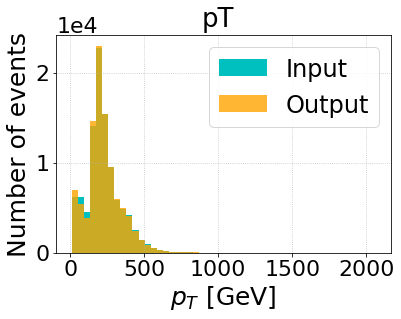

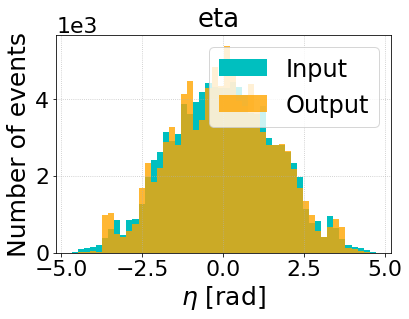

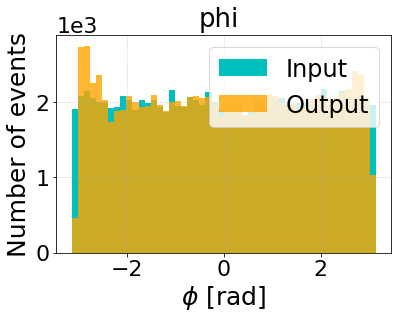

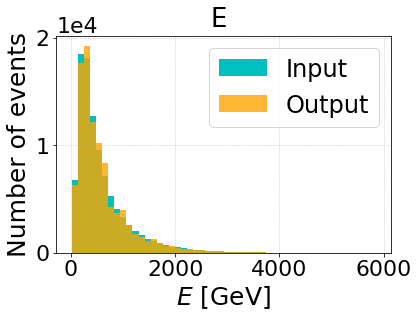

In [14]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    plt.legend()
    ms.sciy()

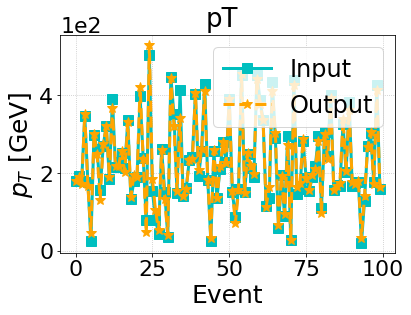

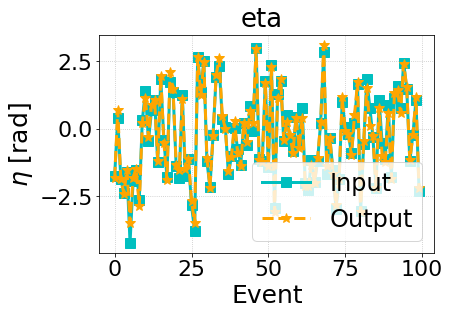

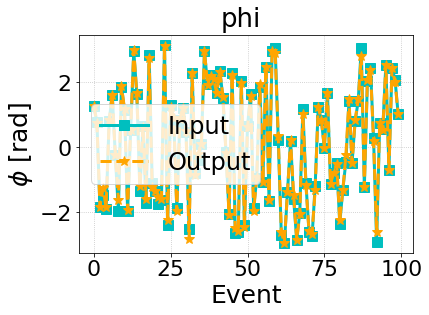

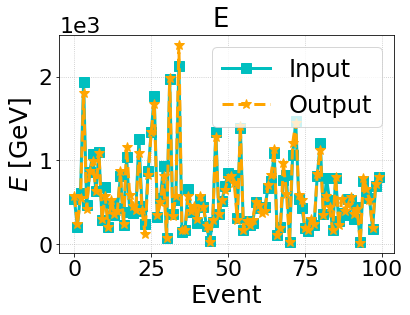

In [15]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [16]:
# Plot input on top of output
idxs = (0, int(1e5))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

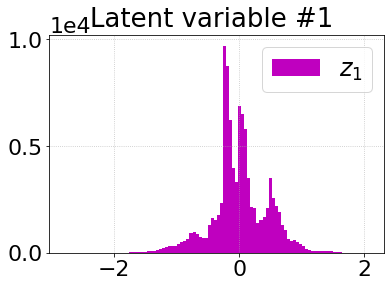

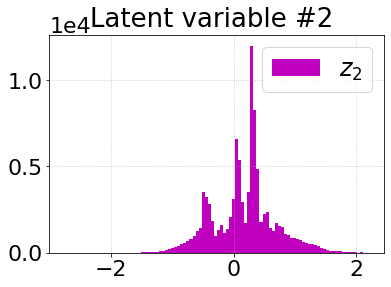

In [19]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m', bins=100)
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()

Text(0, 0.5, '$z_2$')

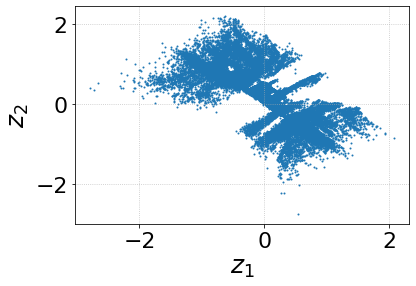

In [18]:
mksz = 1

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')